# Event-based sensitivity analysis (1 hours, 23 in)

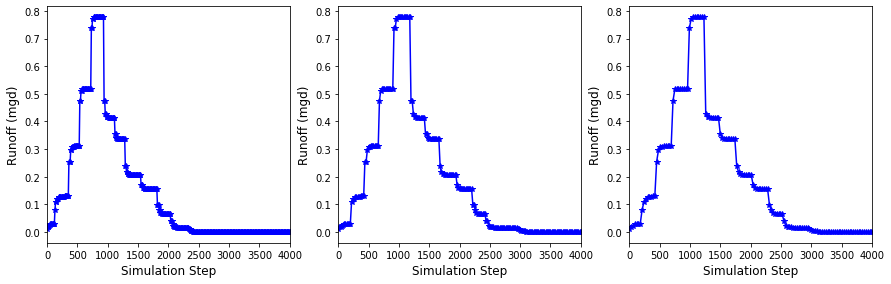

In [3]:
#To Compare the effect of simulation step
from pyswmm import Simulation, Nodes, LidControls, Subcatchments
from matplotlib.ticker import FormatStrFormatter
import numpy as np
import matplotlib.pyplot as plt
import os 
os.chdir("C:/Users/mtorresc/Dropbox/UB-BSA-RENEW/Sensitivity Analysis")

fig = plt.figure(num=None, figsize=(20,20), facecolor='w', edgecolor='k')
for k in range(3):
    with Simulation('Parking20.inp') as sim:
        paso=10*(k+1)
   
        sim.step_advance(paso)
        subcatch = Subcatchments(sim)["HStreet_E-MH-2013"]
        runo=[]
        for step in sim:
            runo.append(subcatch.runoff)


    a_axis=np.arange(len(runo))*paso
    ax = fig.add_subplot(4,4,k+1)
    ax.plot(a_axis,runo,c='b',marker='*')
    ax.set_xlim(0, 4000)
    ax.set_ylabel("Runoff (mgd)",fontsize=12)
    ax.set_xlabel("Simulation Step",fontsize=12)



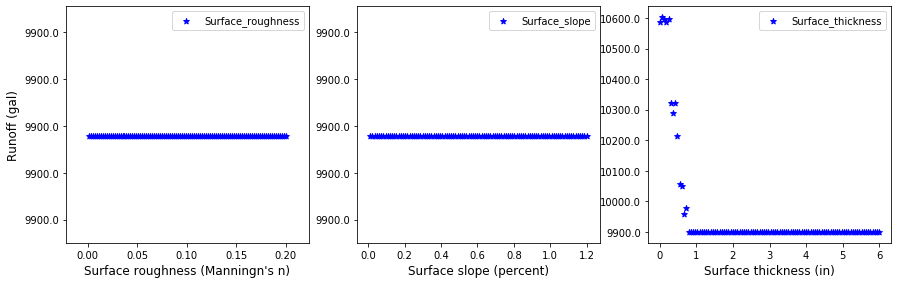

In [19]:
#Parameters layer 1: Surface
from pyswmm import Simulation, Nodes, LidControls, Subcatchments
from matplotlib.ticker import FormatStrFormatter
import numpy as np
import matplotlib.pyplot as plt
import os 
os.chdir("C:/Users/mtorresc/Dropbox/UB-BSA-RENEW/Sensitivity Analysis")

paso=300.0
l_bound=[0.001,0.01,0]
u_bound=[0.2,1.2,6]
parametros = {
        0: "Surface_roughness",
        1: "Surface_slope",             #less than one percent
        2: "Surface_thickness"
}

fig = plt.figure(num=None, figsize=(20,20), facecolor='w', edgecolor='k')

for k in range(3):
    #print(k)
    #print('\n')
    arr=[]
    num=100                                                              
    coef=np.linspace(l_bound[k],u_bound[k],num)                                             
    #print('\n')
    for i in range(num):
        with Simulation('Parking20.inp') as sim:
            sim.step_advance(paso)
            permeable_pavement = LidControls(sim)["PP1"]
            subcatch = Subcatchments(sim)["HStreet_E-MH-2013"]
            outfall= Nodes(sim)["4113"] 
            permeable_pavement.soil.thickness = 1
            if k==0: permeable_pavement.surface.roughness = coef[i]
            if k==1: permeable_pavement.surface.slope = coef[i] 
            
            if k==2: permeable_pavement.surface.thickness = coef[i]

            #Step through a simulation
            total=0
            for step in sim:
                total=total+subcatch.runoff #runoff extracted is in MG
                #total=total+outfall.total_inflow
                #f.write(str(outfall.total_inflow)+"\n")                    
                #print(SC1.runoff)
            #print(' \n')
            #print('Outfall total inflow \n')
            #print(float(total)*paso/(24*60*60))
            arr.append(float(total)*1000000*paso/(24*60*60))
            #f.close()                                                      
       
    f2 = open("param"+str(k)+".txt", "a")                                           
                                   
    for i in range(len(coef)):
        f2.write(str(coef[i])+" "+str(arr[i])+"\n")                          
    f2.close()

    #print('-----------------')
    ax = fig.add_subplot(4,4,k+1)
    ax.scatter(coef,arr,c='b',marker='*')
    ax.legend([parametros[k]],ncol=4,loc=1)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    if k==0: ax.set_ylabel("Runoff (gal)",fontsize=12)
    if k==0: ax.set_xlabel("Surface roughness (Manningn's n)",fontsize=12)
    if k==1: ax.set_xlabel("Surface slope (percent)",fontsize=12)
    if k==2: ax.set_xlabel("Surface thickness (in)",fontsize=12)
    
fig.savefig('SurfParam_event.pdf')

<Figure size 2160x2160 with 0 Axes>

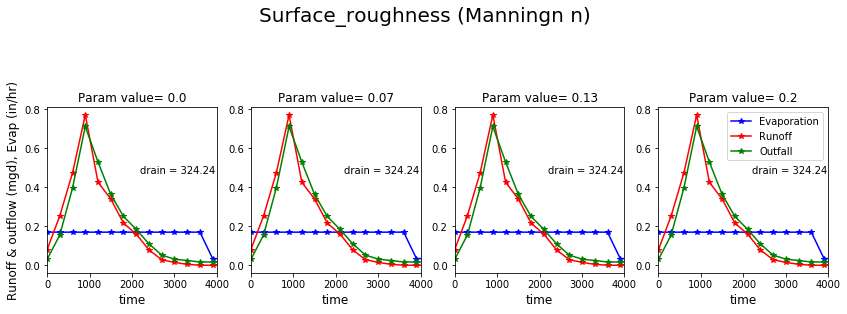

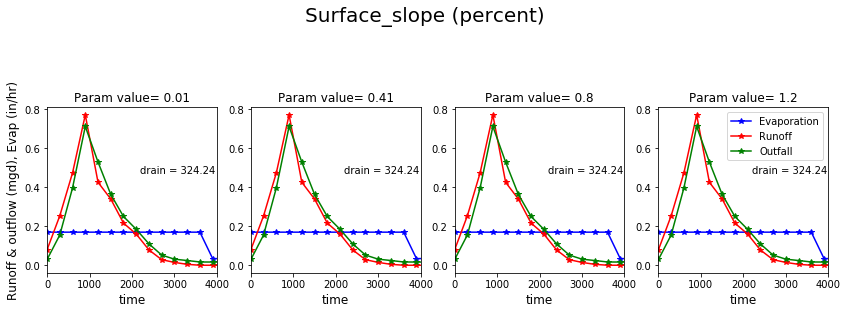

In [20]:
#Comparing the runoff series for non-sensible surface parameters
from pyswmm import SystemStats

fig = plt.figure(num=None, figsize=(30,30), facecolor='w', edgecolor='k')
paso=300.0
l_bound=[0.001,0.01,0]
u_bound=[0.2,1.2,6]
parametros = {
        0: "Surface_roughness (Manningn's n)",
        1: "Surface_slope (percent)",             #less than one percent
}

arr=[]
num=4
SystemRough={}
SystemSlope={}

for k in range(2):
    coef=np.linspace(l_bound[k],u_bound[k],num)
    fig = plt.figure(num=None, figsize=(14,14), facecolor='w', edgecolor='k')
    if k==0: fig.suptitle('Surface_roughness (Manningn n)', fontsize=20)
    if k==1: fig.suptitle('Surface_slope (percent)', fontsize=20)
    for i in range(num):
        with Simulation('Parking20.inp') as sim:
            system_routing = SystemStats(sim)
            sim.step_advance(paso)
            permeable_pavement = LidControls(sim)["PP1"]
            subcatch = Subcatchments(sim)["HStreet_E-MH-2013"]
            outfall= Nodes(sim)["4113"]
            permeable_pavement.soil.thickness = 1
            if k==0: permeable_pavement.surface.roughness = coef[i]
            if k==1: permeable_pavement.surface.slope = coef[i] 

            evapor=[]
            runo=[]
            infil=[]
            out=[]
            for step in sim:
                evapor.append(subcatch.evaporation_loss)
                infil.append(subcatch.infiltration_loss)
                runo.append(subcatch.runoff)
                out.append(outfall.total_inflow)           

            #print('\n')
            if k==0: SystemRough[coef[i]]=system_routing.runoff_stats
            if k==1: SystemSlope[coef[i]]=system_routing.runoff_stats

        a_axis=np.arange(len(runo))*paso
        ax = fig.add_subplot(4,4,i+1)
        ax.plot(a_axis,evapor,c='b',marker='*',label='Evaporation')
        ax.plot(a_axis,runo,c='r',marker='*',label='Runoff')
        #ax.plot(a_axis,infil,c='g',marker='*')
        ax.plot(a_axis,out,c='g',marker='*',label='Outfall')
        if k==0: ax.annotate('drain = '+ str(round(SystemRough[coef[i]]['drains'],2)), xy=(1,1),xycoords='axes fraction', xytext=(0.55,0.6), textcoords='axes fraction')
        if k==1: ax.annotate('drain = '+ str(round(SystemSlope[coef[i]]['drains'],2)), xy=(1,1),xycoords='axes fraction', xytext=(0.55,0.6), textcoords='axes fraction')
        if i==3: ax.legend(bbox_to_anchor=(1, 1), loc=1)
        ax.set_title('Param value= ' + str(round(coef[i],2)))
        ax.set_xlim(0, 4000)
        if i==0: ax.set_ylabel("Runoff & outflow (mgd), Evap (in/hr)",fontsize=12)
        ax.set_xlabel("time",fontsize=12)

### Parameters layer 2: Pavement

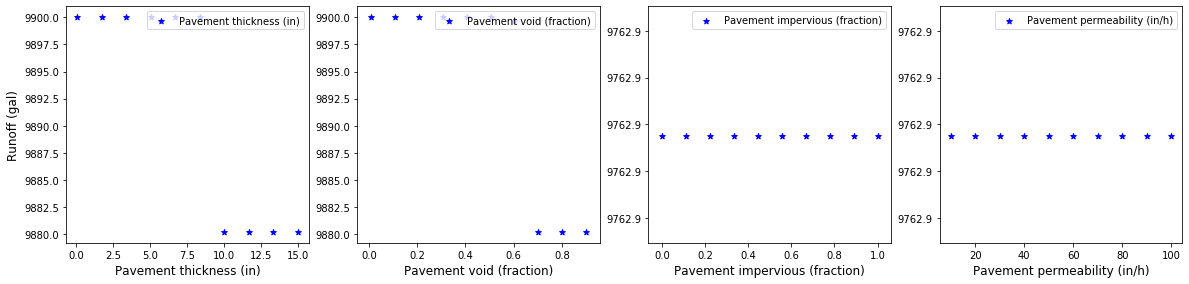

In [22]:
#Parameters layer 2: Pavement

from pyswmm import Simulation, Nodes, LidControls, Subcatchments
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import os 
os.chdir("C:/Users/mtorresc/Dropbox/UB-BSA-RENEW/Sensitivity Analysis")

parametros=8
paso=300.0
l_bound=[0.1,0.01,0,10]
u_bound=[15,0.9,1,100]
parametros = {
        0: "Pavement thickness (in)",
        1: "Pavement void (fraction)",
        2: "Pavement impervious (fraction)",
        3: "Pavement permeability (in/h)",
        #4: "Clogging factor",
}

fig = plt.figure(num=None, figsize=(20,20), facecolor='w', edgecolor='k')
for k in range(4):
    #print(k)
    #print('\n')
    arr=[]
    num=10                                                         
    coef=np.linspace(l_bound[k],u_bound[k],num)                                             
    #print('\n')
    for i in range(num):
        with Simulation('Parking20.inp') as sim:    
            sim.step_advance(paso)
            permeable_pavement = LidControls(sim)["PP1"]
            #
            #permeable_pavement.pavement.thickness = 5
            
            subcatch = Subcatchments(sim)["HStreet_E-MH-2013"]
            outfall= Nodes(sim)["4113"] 
            if k==0: permeable_pavement.pavement.thickness = coef[i]
            if k==0 or k==1: permeable_pavement.soil.thickness = 1
            if k==1: permeable_pavement.pavement.void_fraction = coef[i]  
            if k==2: permeable_pavement.pavement.impervious_fraction = coef[i] #Doesn't change even with "extreme" thickness of the layers
            if k==3: permeable_pavement.pavement.k_saturated = coef[i]  #Doesn't change even with "extreme" values of impervious fraction
            if k==4: permeable_pavement.pavement.clog_factor = coef[i]  
            
            #Step through a simulation
            total=0
            for step in sim:
                total=total+subcatch.runoff
                #total=total+outfall.total_inflow
                #f.write(str(outfall.total_inflow)+"\n")                    
                #print(SC1.runoff)
            #print(' \n')
            #print('Outfall total inflow \n')
            #print(float(total)*paso/(24*60*60))
            arr.append(float(total)*1000000*paso/(24*60*60))
            #f.close()                                                      
       
    f2 = open("param"+str(k)+".txt", "a")                                           
                                   
    for i in range(len(coef)):
        f2.write(str(coef[i])+" "+str(arr[i])+"\n")                          
    f2.close()
    
    ax = fig.add_subplot(4,4,k+1)
    ax.scatter(coef,arr,c='b',marker='*')
    ax.legend([parametros[k]],ncol=4,loc=1)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    if k==0: ax.set_ylabel("Runoff (gal)",fontsize=12)
    if k==0: ax.set_xlabel("Pavement thickness (in)",fontsize=12)
    if k==1: ax.set_xlabel("Pavement void (fraction)",fontsize=12)
    if k==2: ax.set_xlabel("Pavement impervious (fraction)",fontsize=12)
    if k==3: ax.set_xlabel("Pavement permeability (in/h)",fontsize=12)
        
fig.savefig('PavementParam_event.pdf')
    

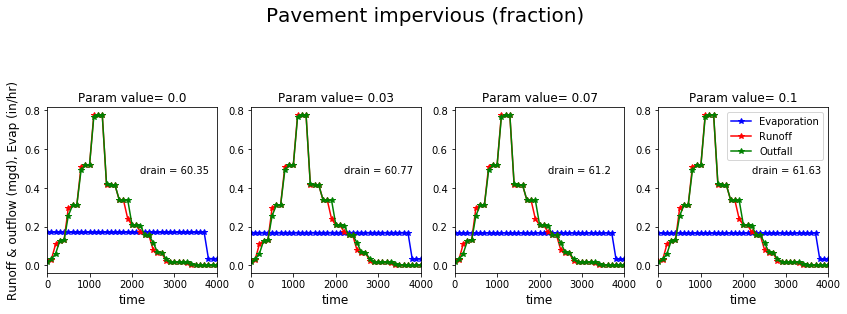

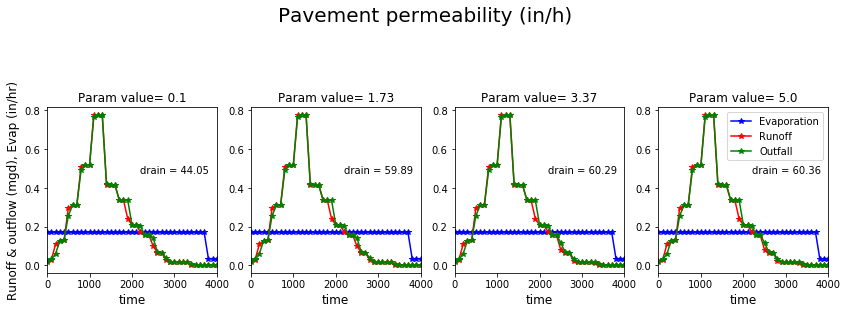

In [23]:
#Comparing the runoff series for non-sensible pavement parameters
from pyswmm import SystemStats
import numpy as np

l_bound=[0,0.1]
u_bound=[0.1,5]#100
parametros = {
        0: "Pavement impervious (fraction)",
        1: "Pavement permeability (in/h)",
}

paso=100
arr=[]
num=4
SystemImpervFrac={}
SystemPerm={}

for k in range(2):
    coef=np.linspace(l_bound[k],u_bound[k],num)
    fig = plt.figure(num=None, figsize=(14,14), facecolor='w', edgecolor='k')
    if k==0: fig.suptitle('Pavement impervious (fraction)', fontsize=20)
    if k==1: fig.suptitle('Pavement permeability (in/h)', fontsize=20)
    for i in range(num):
        with Simulation('Parking20.inp') as sim:
            system_routing = SystemStats(sim)
            sim.step_advance(paso)
            permeable_pavement = LidControls(sim)["PP1"]
            subcatch = Subcatchments(sim)["HStreet_E-MH-2013"]
            outfall= Nodes(sim)["4113"] 
            #if k==0: permeable_pavement.pavement.thickness = 1
            if k==0: permeable_pavement.pavement.impervious_fraction = coef[i]
            if k==1: permeable_pavement.pavement.k_saturated = coef[i]

            evapor=[]
            runo=[]
            infil=[]
            out=[]
            for step in sim:
                evapor.append(subcatch.evaporation_loss)
                infil.append(subcatch.infiltration_loss)
                runo.append(subcatch.runoff)
                out.append(outfall.total_inflow)           

            #print('\n')
            if k==0: SystemImpervFrac[coef[i]]=system_routing.runoff_stats
            if k==1: SystemPerm[coef[i]]=system_routing.runoff_stats

        a_axis=np.arange(len(runo))*paso
        ax = fig.add_subplot(4,4,i+1)
        ax.plot(a_axis,evapor,c='b',marker='*',label='Evaporation')
        ax.plot(a_axis,runo,c='r',marker='*',label='Runoff')
        #ax.plot(a_axis,infil,c='g',marker='*')
        ax.plot(a_axis,out,c='g',marker='*',label='Outfall')
        if k==0: ax.annotate('drain = '+ str(round(SystemImpervFrac[coef[i]]['drains'],2)), xy=(1,1),xycoords='axes fraction', xytext=(0.55,0.6), textcoords='axes fraction')
        if k==1: ax.annotate('drain = '+ str(round(SystemPerm[coef[i]]['drains'],2)), xy=(1,1),xycoords='axes fraction', xytext=(0.55,0.6), textcoords='axes fraction')
        if i==3: ax.legend(bbox_to_anchor=(1, 1), loc=1)
        ax.set_title('Param value= ' + str(round(coef[i],2)))
        ax.set_xlim(0, 4000)
        if i==0: ax.set_ylabel("Runoff & outflow (mgd), Evap (in/hr)",fontsize=12)
        ax.set_xlabel("time",fontsize=12)



### Parameters layer 3: Soil

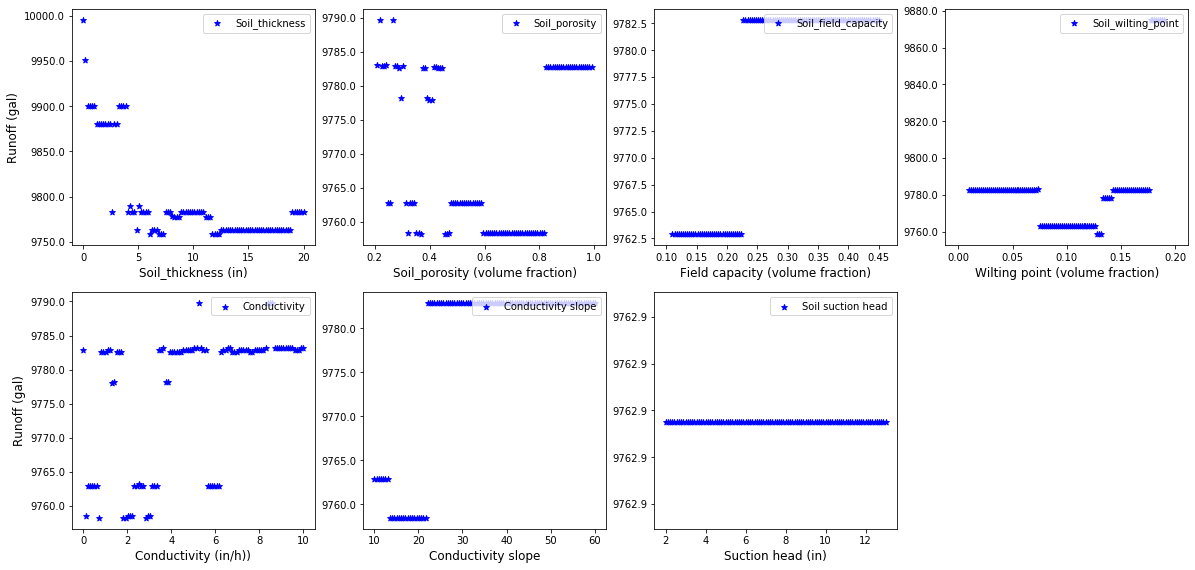

In [28]:
#Parameters layer 3: Soil

from pyswmm import Simulation, Nodes, LidControls, Subcatchments
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import os 
os.chdir("C:/Users/mtorresc/Dropbox/UB-BSA-RENEW/Sensitivity Analysis")

parametros=8
paso=300.0
l_bound=[0,0.21,0.11,0.01,0.0001,10,2]
u_bound=[20,0.99,0.45,0.19,10,60,13]
parametros = {
        0: "Soil_thickness",
        1: "Soil_porosity",
        2: "Soil_field_capacity",
        3: "Soil_wilting_point",
        4: "Conductivity",
        5: "Conductivity slope",
        6: "Soil suction head"
}

fig = plt.figure(num=None, figsize=(20,20), facecolor='w', edgecolor='k')
for k in range(7):
    #print(k)
    #print('\n')
    arr=[]
    num=100                                                           
    coef=np.linspace(l_bound[k],u_bound[k],num)                                             
    #print('\n')
    for i in range(num):
        with Simulation('Parking20.inp') as sim:    
            sim.step_advance(paso)
            permeable_pavement = LidControls(sim)["PP1"]
            subcatch_object = Subcatchments(sim)["HStreet_E-MH-2013"]
            outfall= Nodes(sim)["4113"] 
            if k==0: permeable_pavement.soil.thickness = coef[i]
            if k==1: permeable_pavement.soil.porosity = coef[i]                                      
            if k==2: permeable_pavement.soil.field_capacity = coef[i]
            if k==3: permeable_pavement.soil.wilting_point = coef[i]
            if k==4: permeable_pavement.soil.k_saturated = coef[i]
            if k==5: permeable_pavement.soil.k_slope = coef[i]  
            #if k==6: permeable_pavement.soil.thickness = 15
            #if k==6: permeable_pavement.soil.k_saturated = 0.02
            #if k==6: permeable_pavement.soil.k_slope = 10
            if k==6: permeable_pavement.soil.suction_head = coef[i]         
            
            #Step through a simulation
            total=0
            for step in sim:
                total=total+subcatch_object.runoff
                #total=total+outfall.total_inflow
                #f.write(str(outfall.total_inflow)+"\n")                    
                #print(SC1.runoff)
            #print(' \n')
            #print('Outfall total inflow \n')
            #print(float(total)*paso/(24*60*60))
            arr.append(float(total)*1000000*paso/(24*60*60))
            #f.close()                                                      
       
    f2 = open("param"+str(k)+".txt", "a")                                           
                                   
    for i in range(len(coef)):
        f2.write(str(coef[i])+" "+str(arr[i])+"\n")                          
    f2.close()
    
    ax = fig.add_subplot(4,4,k+1)
    ax.scatter(coef,arr,c='b',marker='*')
    ax.legend([parametros[k]],ncol=4,loc=1)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    if k==0 or k==4: ax.set_ylabel("Runoff (gal)",fontsize=12)
    if k==0: ax.set_xlabel("Soil_thickness (in)",fontsize=12)
    if k==1: ax.set_xlabel("Soil_porosity (volume fraction)",fontsize=12)
    if k==2: ax.set_xlabel("Field capacity (volume fraction)",fontsize=12)
    if k==3: ax.set_xlabel("Wilting point (volume fraction)",fontsize=12)
    if k==4: ax.set_xlabel("Conductivity (in/h))",fontsize=12)
    if k==5: ax.set_xlabel("Conductivity slope",fontsize=12)
    if k==6: ax.set_xlabel("Suction head (in)",fontsize=12)
    
fig.savefig('SoilParam.pdf')
    

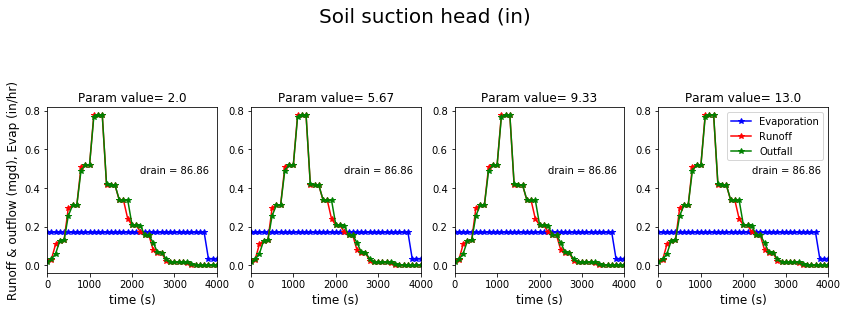

In [29]:
#Comparing the runoff series for non-sensible pavement parameters
from pyswmm import SystemStats
import numpy as np

l_bound=[2]
u_bound=[13]#even unrealistic parameters show no effect 0.0000002-100000
parametros = {0:"Soil suction head (in)"}

paso=100
arr=[]
num=4
SystemSoilSuction={}

for k in range(1):
    coef=np.linspace(l_bound[k],u_bound[k],num)
    fig = plt.figure(num=None, figsize=(14,14), facecolor='w', edgecolor='k')
    if k==0: fig.suptitle('Soil suction head (in)', fontsize=20)
    
    for i in range(num):
        with Simulation('Parking20.inp') as sim:
            system_routing = SystemStats(sim)
            sim.step_advance(paso)
            permeable_pavement = LidControls(sim)["PP1"]
            subcatch = Subcatchments(sim)["HStreet_E-MH-2013"]
            outfall= Nodes(sim)["4113"] 
            if k==0: permeable_pavement.pavement.thickness = 1
            if k==0: permeable_pavement.soil.thickness = 5
            if k==0: permeable_pavement.soil.k_saturated = 0.02
            if k==0: permeable_pavement.soil.k_slope = 0.001
            if k==0: permeable_pavement.soil.suction_head = coef[i]  

            evapor=[]
            runo=[]
            infil=[]
            out=[]
            for step in sim:
                evapor.append(subcatch.evaporation_loss)
                infil.append(subcatch.infiltration_loss)
                runo.append(subcatch.runoff)
                out.append(outfall.total_inflow)           

            #print('\n')
            if k==0: SystemSoilSuction[coef[i]]=system_routing.runoff_stats
            

        a_axis=np.arange(len(runo))*paso
        ax = fig.add_subplot(4,4,i+1)
        ax.plot(a_axis,evapor,c='b',marker='*',label='Evaporation')
        ax.plot(a_axis,runo,c='r',marker='*',label='Runoff')
        #ax.plot(a_axis,infil,c='g',marker='*')
        ax.plot(a_axis,out,c='g',marker='*',label='Outfall')
        if k==0: ax.annotate('drain = '+ str(round(SystemSoilSuction[coef[i]]['drains'],2)), xy=(1,1),xycoords='axes fraction', xytext=(0.55,0.6), textcoords='axes fraction')
        if i==3: ax.legend(bbox_to_anchor=(1, 1), loc=1)
        ax.set_title('Param value= ' + str(round(coef[i],2)))
        ax.set_xlim(0, 4000)
        if i==0: ax.set_ylabel("Runoff & outflow (mgd), Evap (in/hr)",fontsize=12)
        ax.set_xlabel("time (s)",fontsize=12)



In [8]:
### Parameters layer 4: Storage and Underdrain

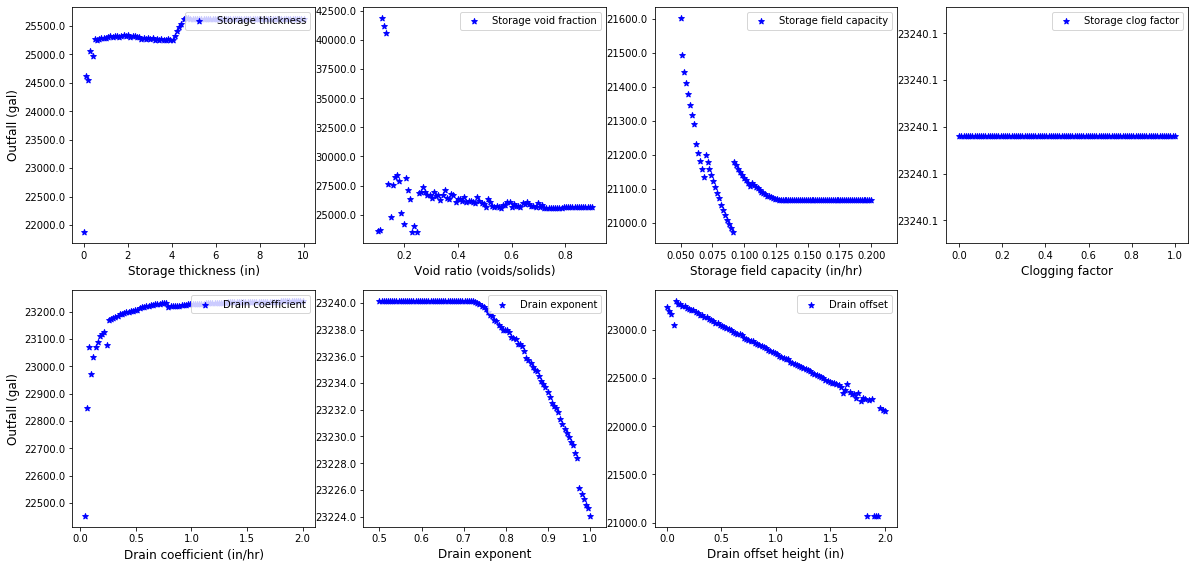

In [34]:
#Parameters layer 4: Storage and Underdrain

from pyswmm import Simulation, Nodes, LidControls, Subcatchments
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import os 
os.chdir("C:/Users/mtorresc/Dropbox/UB-BSA-RENEW/Sensitivity Analysis")

parametros=8
paso=300.0
l_bound=[0,0.1,0.05,0,0.039,0.5,0]
u_bound=[10,0.9,0.2,1,2,1,2]
parametros = {
        0: "Storage thickness", #storage.thickness
        1: "Storage void fraction", #storage.void_fraction
        2: "Storage field capacity", #storage.k_saturated
        3: "Storage clog factor", #storage.clog_factor
        4: "Drain coefficient", #drain.coefficient
        5: "Drain exponent",#drain.exponent
        6: "Drain offset" #drain.offset
}

fig = plt.figure(num=None, figsize=(20,20), facecolor='w', edgecolor='k')
for k in range(7):
    #print(k)
    #print('\n')
    arr=[]
    num=100                                                           
    coef=np.linspace(l_bound[k],u_bound[k],num)                                             
    #print('\n')
    for i in range(num):
        with Simulation('Parking20_LargerRainfall.inp') as sim:    
            sim.step_advance(paso)
            permeable_pavement = LidControls(sim)["PP1"]
            
            subcatch = Subcatchments(sim)["HStreet_E-MH-2013"]
            outfall= Nodes(sim)["4113"] 
            if k==0 or k==1: permeable_pavement.soil.thickness = 3
            if k==0: permeable_pavement.drain.coefficient = 0.1
            if k==0: permeable_pavement.storage.thickness = coef[i]
            if k==1: permeable_pavement.storage.thickness = 2
            if k==1: permeable_pavement.storage.void_fraction = coef[i]                                      
            if k==2: permeable_pavement.storage.k_saturated = coef[i]
            if k==3: permeable_pavement.storage.clog_factor = coef[i]
            if k==4: permeable_pavement.drain.coefficient = coef[i]
            if k==5: permeable_pavement.drain.exponent = coef[i]         
            if k==6: permeable_pavement.drain.offset = coef[i]         
            
            #Step through a simulation
            total=0
            for step in sim:
                #total=total+subcatch.runoff
                total=total+outfall.total_inflow
                #f.write(str(outfall.total_inflow)+"\n")                    
                #print(SC1.runoff)
            #print(' \n')
            #print('Outfall total inflow \n')
            #print(float(total)*paso/(24*60*60))
            arr.append(float(total)*1000000*paso/(24*60*60))
            #f.close()                                                      
       
    f2 = open("param"+str(k)+".txt", "a")                                           
                                   
    for i in range(len(coef)):
        f2.write(str(coef[i])+" "+str(arr[i])+"\n")                          
    f2.close()
    
    ax = fig.add_subplot(4,4,k+1)
    ax.scatter(coef,arr,c='b',marker='*')
    ax.legend([parametros[k]],ncol=4,loc=1)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    if k==0 or k==4: ax.set_ylabel("Outfall (gal)",fontsize=12)
    if k==0: ax.set_xlabel("Storage thickness (in)",fontsize=12)
    if k==1: ax.set_xlabel("Void ratio (voids/solids)",fontsize=12)
    if k==2: ax.set_xlabel("Storage field capacity (in/hr)",fontsize=12)
    if k==3: ax.set_xlabel("Clogging factor",fontsize=12)
    if k==4: ax.set_xlabel("Drain coefficient (in/hr)",fontsize=12)
    if k==5: ax.set_xlabel("Drain exponent",fontsize=12)
    if k==6: ax.set_xlabel("Drain offset height (in)",fontsize=12)
        
fig.savefig('Underdrain_StorageParam_event.pdf')

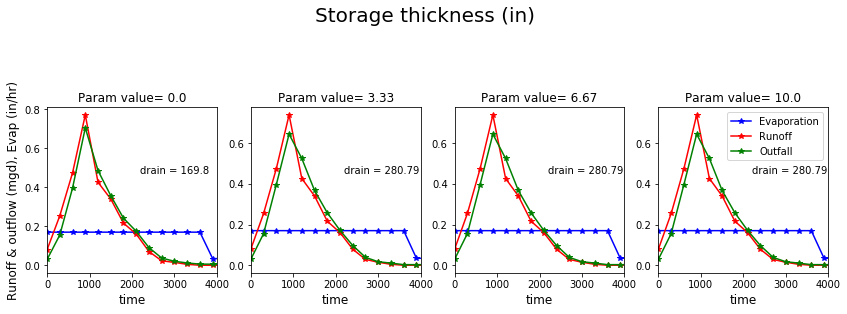

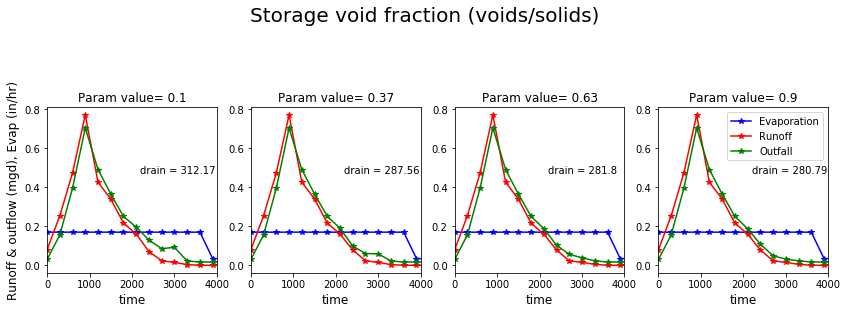

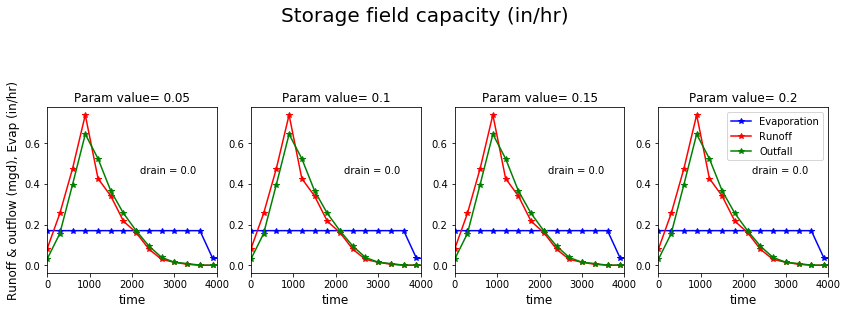

In [32]:
#Comparing the runoff series for storage and underdrain
from pyswmm import SystemStats
import numpy as np

paso=300.0
l_bound=[0,0.1,0.05]
u_bound=[10,0.9,0.2]
parametros = {
        0: "Storage thickness", #storage.thickness
        1: "Storage void fraction", #storage.void_fraction
        2: "Storage field capacity", #storage.k_saturated
}

arr=[]
num=4
SystemStorageThick={}
SystemStorageVoid={}
SystemStorageField={}

for k in range(3):
    coef=np.linspace(l_bound[k],u_bound[k],num)
    fig = plt.figure(num=None, figsize=(14,14), facecolor='w', edgecolor='k')
    if k==0: fig.suptitle('Storage thickness (in)', fontsize=20)
    if k==1: fig.suptitle('Storage void fraction (voids/solids)', fontsize=20)
    if k==2: fig.suptitle('Storage field capacity (in/hr)', fontsize=20)
        
    for i in range(num):
        with Simulation('Parking20.inp') as sim:
            system_routing = SystemStats(sim)
            sim.step_advance(paso)
            permeable_pavement = LidControls(sim)["PP1"]
            subcatch = Subcatchments(sim)["HStreet_E-MH-2013"]
            outfall= Nodes(sim)["4113"]
            if k==0 or k==1: permeable_pavement.soil.thickness = 3
            if k==0: permeable_pavement.drain.coefficient = 0.1
            if k==0: permeable_pavement.storage.thickness = coef[i]
            if k==1: permeable_pavement.storage.thickness = 2
            if k==1: permeable_pavement.storage.void_fraction = coef[i]                                      
            if k==2: permeable_pavement.storage.k_saturated = coef[i]
             
            evapor=[]
            runo=[]
            infil=[]
            out=[]
            for step in sim:
                evapor.append(subcatch.evaporation_loss)
                infil.append(subcatch.infiltration_loss)
                runo.append(subcatch.runoff)
                out.append(outfall.total_inflow)           

            #print('\n')
            if k==0: SystemStorageThick[coef[i]]=system_routing.runoff_stats
            if k==1: SystemStorageVoid[coef[i]]=system_routing.runoff_stats
            if k==2: SystemStorageField[coef[i]]=system_routing.runoff_stats
           
        a_axis=np.arange(len(runo))*paso
        ax = fig.add_subplot(4,4,i+1)
        ax.plot(a_axis,evapor,c='b',marker='*',label='Evaporation')
        ax.plot(a_axis,runo,c='r',marker='*',label='Runoff')
        #ax.plot(a_axis,infil,c='g',marker='*')
        ax.plot(a_axis,out,c='g',marker='*',label='Outfall')
        if k==0: ax.annotate('drain = '+ str(round(SystemStorageThick[coef[i]]['drains'],2)), xy=(1,1),xycoords='axes fraction', xytext=(0.55,0.6), textcoords='axes fraction')
        if k==1: ax.annotate('drain = '+ str(round(SystemStorageVoid[coef[i]]['drains'],2)), xy=(1,1),xycoords='axes fraction', xytext=(0.55,0.6), textcoords='axes fraction')
        if k==2: ax.annotate('drain = '+ str(round(SystemStorageField[coef[i]]['drains'],2)), xy=(1,1),xycoords='axes fraction', xytext=(0.55,0.6), textcoords='axes fraction')
        if i==3: ax.legend(bbox_to_anchor=(1, 1), loc=1)
        ax.set_title('Param value= ' + str(round(coef[i],2)))
        ax.set_xlim(0, 4000)
        if i==0: ax.set_ylabel("Runoff & outflow (mgd), Evap (in/hr)",fontsize=12)
        ax.set_xlabel("time",fontsize=12)

#rg1 = RainGages(sim)["Gage1"]

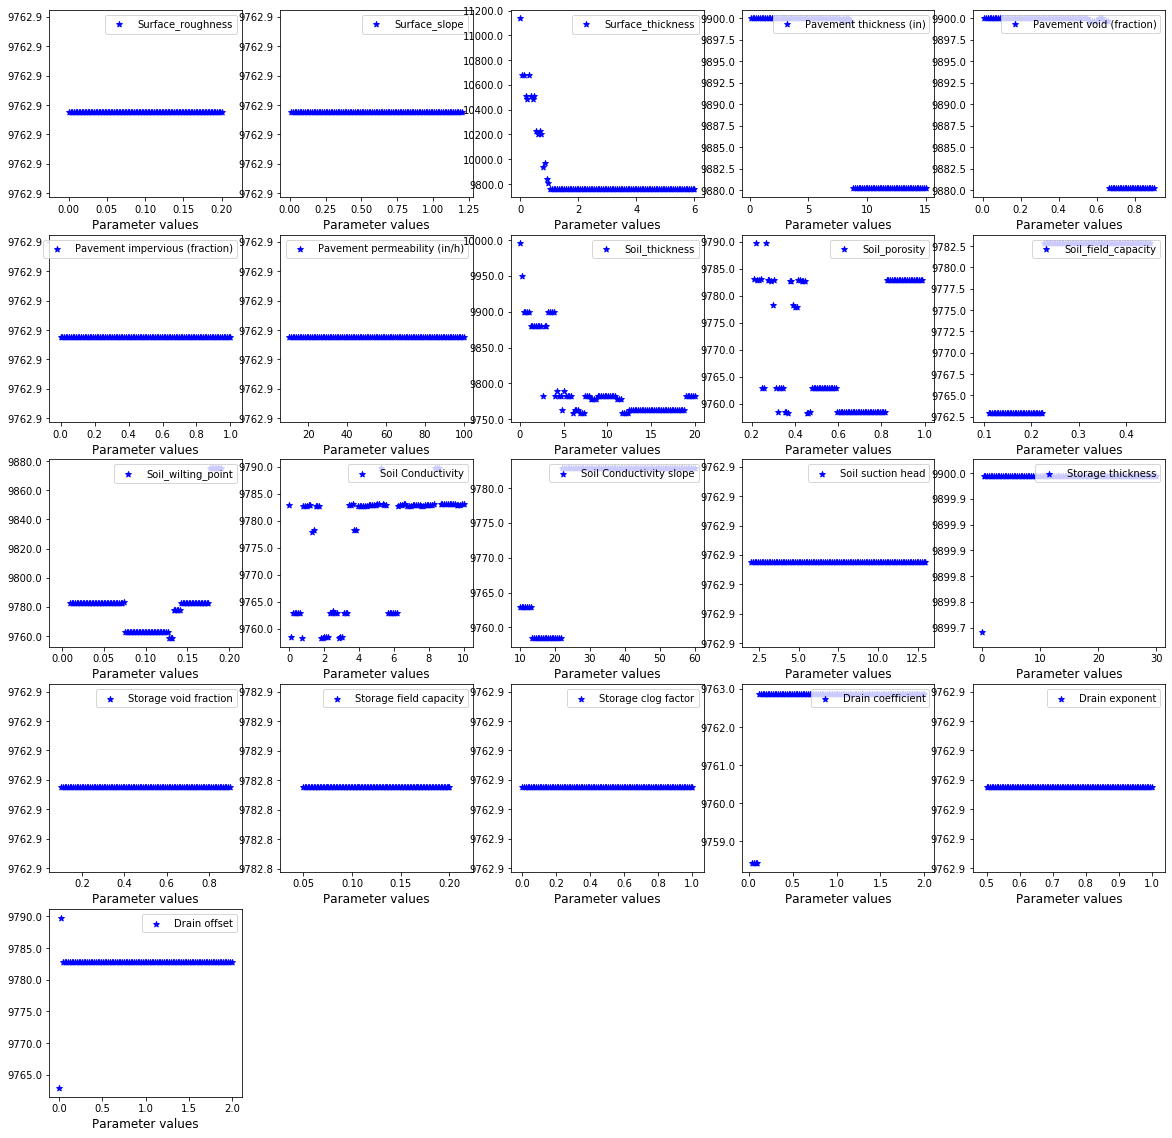

In [11]:
#Trying to put all the figures in one
from pyswmm import Simulation, Nodes, LidControls, Subcatchments
from matplotlib.ticker import FormatStrFormatter
import numpy as np
import matplotlib.pyplot as plt
import os 
os.chdir("C:/Users/mtorresc/Dropbox/UB- BSA-RENEW/Sensitivity Analysis")

paso=300.0
l_bound=[0.001,0.01,0,0.1,0.01,0,10,0,0.21,0.11,0.01,0.0001,10,2,0,0.1,0.05,0,0.039,0.5,0]
u_bound=[0.2,1.2,6,15,0.9,1,100,20,0.99,0.45,0.19,10,60,13,30,0.9,0.2,1,2,1,2]
parametros = {
        0: "Surface_roughness",
        1: "Surface_slope",             #less than one percent
        2: "Surface_thickness",
        3: "Pavement thickness (in)",
        4: "Pavement void (fraction)",
        5: "Pavement impervious (fraction)",
        6: "Pavement permeability (in/h)",        
        7: "Soil_thickness",
        8: "Soil_porosity",
        9: "Soil_field_capacity",
        10: "Soil_wilting_point",
        11: "Soil Conductivity",
        12: "Soil Conductivity slope",
        13: "Soil suction head",
        14: "Storage thickness", #storage.thickness
        15: "Storage void fraction", #storage.void_fraction
        16: "Storage field capacity", #storage.k_saturated
        17: "Storage clog factor", #storage.clog_factor
        18: "Drain coefficient", #drain.coefficient
        19: "Drain exponent",#drain.exponent
        20: "Drain offset" #drain.offset
}

fig = plt.figure(num=None, figsize=(20,20), facecolor='w', edgecolor='k')

for k in range(21):
    #print(k)
    #print('\n')
    arr=[]
    num=100                                                              
    coef=np.linspace(l_bound[k],u_bound[k],num)                                             
    #print('\n')
    for i in range(num):
        with Simulation('Parking20.inp') as sim:
            sim.step_advance(paso)
            permeable_pavement = LidControls(sim)["PP1"]
            #permeable_pavement.soil.thickness = 5
            #permeable_pavement.storage.thickness = 5
            subcatch = Subcatchments(sim)["HStreet_E-MH-2013"]
            outfall= Nodes(sim)["4113"] 
            if k==0: permeable_pavement.surface.roughness = coef[i]
            if k==1: permeable_pavement.surface.slope = coef[i] 
            if k==2 : permeable_pavement.soil.thickness = 0.25
            if k==2: permeable_pavement.surface.thickness = coef[i]
            if k==3: permeable_pavement.pavement.thickness = coef[i]
            if k==3 or k==4: permeable_pavement.soil.thickness = 1
            if k==4: permeable_pavement.pavement.void_fraction = coef[i]  
            if k==5: permeable_pavement.pavement.impervious_fraction = coef[i] #Doesn't change even with "extreme" thickness of the layers
            if k==6: permeable_pavement.pavement.k_saturated = coef[i]  #Doesn't change even with "extreme" values of impervious fraction
            if k==7: permeable_pavement.soil.thickness = coef[i]
            if k==8: permeable_pavement.soil.porosity = coef[i]                                      
            if k==9: permeable_pavement.soil.field_capacity = coef[i]
            if k==10: permeable_pavement.soil.wilting_point = coef[i]
            if k==11: permeable_pavement.soil.k_saturated = coef[i]
            if k==12: permeable_pavement.soil.k_slope = coef[i]         
            if k==13: permeable_pavement.soil.suction_head = coef[i]
            if k==14: permeable_pavement.soil.thickness = 1
            if k==14: permeable_pavement.storage.thickness = coef[i]
            if k==15: permeable_pavement.storage.void_fraction = coef[i]                                      
            if k==16: permeable_pavement.storage.k_saturated = coef[i]
            if k==17: permeable_pavement.storage.clog_factor = coef[i]
            if k==18: permeable_pavement.drain.coefficient = coef[i]
            if k==19: permeable_pavement.drain.exponent = coef[i]         
            if k==20: permeable_pavement.drain.offset = coef[i] 

            #Step through a simulation
            total=0
            for step in sim:
                total=total+subcatch.runoff
                #total=total+outfall.total_inflow
                #f.write(str(outfall.total_inflow)+"\n")                    
                #print(SC1.runoff)
            #print(' \n')
            #print('Outfall total inflow \n')
            #print(float(total)*paso/(24*60*60))
            arr.append(float(total)*1000000*paso/(24*60*60))
            #f.close()                                                      
       
    f2 = open("param"+str(k)+".txt", "a")                                           
                                   
    for i in range(len(coef)):
        f2.write(str(coef[i])+" "+str(arr[i])+"\n")                          
    f2.close()

    #print('-----------------')
    ax = fig.add_subplot(5,5,k+1)
    ax.scatter(coef,arr,c='b',marker='*')
    ax.legend([parametros[k]],ncol=4,loc=1)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    #if k==0: ax.set_ylabel("Runoff (gal)",fontsize=12)
    #if k==7: ax.set(xlim=(8000, 13000))
    ax.set_xlabel("Parameter values",fontsize=12)
    
fig.savefig('AllParam.pdf')